In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from scipy.signal import firwin
import tensorflow as tf

sys.path.append('..')

from sleeprnn.nn import wave_augment
from sleeprnn.nn.layers import signal_decomposition_bandpass
from sleeprnn.helpers import reader
from sleeprnn.data import utils
from sleeprnn.common import constants, pkeys, viz

viz.notebook_full_width()
%matplotlib inline

# EEG Segment

In [3]:
# Choose segment
subject_id = 1
which_kc_stamp = 195
left_context = 3
right_context = 7

# Load data
dataset = reader.load_dataset(constants.MASS_SS_NAME, verbose=False)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME, verbose=False)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs
print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

# Extract chosen segment
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)
segment_signal = signal[start_sample:end_sample]
segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
time_axis = np.arange(start_sample, end_sample) / fs
segment_label_ss = np.zeros(end_sample)
for ss in segment_stamps_ss:
    segment_label_ss[ss[0]:ss[1]+1] = 1
segment_label_ss = segment_label_ss[start_sample:]
print("Segment of %d samples extracted." % segment_signal.size)

# Plotting functions
general_lw = 1.0
signal_lw = 0.6
mark_lw = 3
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['red']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']


def draw_signal(
    ax, my_signal, y_min=-120, y_max=120, yticks=[-50, -25, 0, 25, 50], 
    xlabel='Intervals of 1 s', ylabel='EEG ($\mu$V)', 
    linewidth=signal_lw, color=signal_color
):
    ax.plot(time_axis, my_signal, linewidth=linewidth, color=color)
    ax.set_xlabel(xlabel, fontsize=viz.FONTSIZE_GENERAL)
    ax.set_ylabel(ylabel, fontsize=viz.FONTSIZE_GENERAL)
    ax.set_yticks(yticks)
    ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
    ax.set_ylim([y_min, y_max])
    ax.set_xticks([])
    ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both',length=0)
    return ax
    

def draw_stamps(ax, my_stamps_ss, my_stamps_kc, ss_loc=-60, kc_loc=-70):
    # SS
    label_used = False
    for stamp in my_stamps_ss:
        label = None if label_used else "Sleep Spindle"
        label_used = True
        ax.plot(stamp / fs, [ss_loc, ss_loc], label=label, color=ss_color, linewidth=mark_lw)
    # KC
    label_used = False
    for stamp in my_stamps_kc:
        label = None if label_used else "K-Complex"
        label_used = True
        ax.plot(stamp / fs, [kc_loc, kc_loc], label=label, color=kc_color, linewidth=mark_lw)
    return ax

1044 SS stamps.
409 KC stamps.
Segment of 2000 samples extracted.


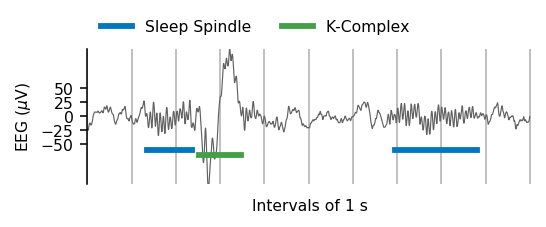

In [4]:
fig, ax = plt.subplots(1, 1, dpi=140, figsize=(4, 1.5))
ax = draw_signal(ax, segment_signal)
ax = draw_stamps(ax, segment_stamps_ss, segment_stamps_kc)
ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
plt.tight_layout()
plt.show()

# Check signal decomposition in bands

In [7]:
tf.reset_default_graph()
bands_tf = signal_decomposition_bandpass(segment_signal.reshape(1, -1), fs, 'bands')
with tf.Session() as sess:
    bands = sess.run(bands_tf)

Applying lowpass filter with cutoff 4 Hz
Applying lowpass filter with cutoff 8 Hz
Applying lowpass filter with cutoff 16 Hz


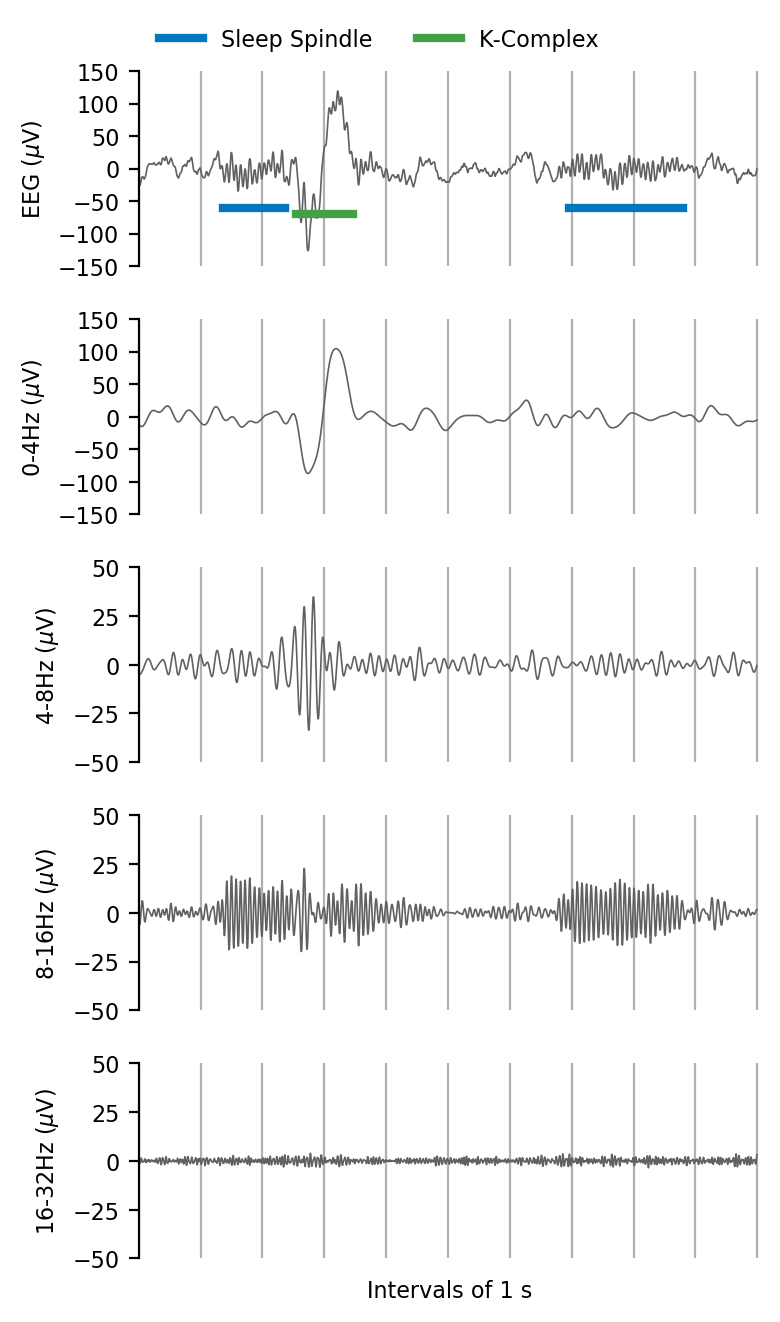

In [19]:
fig, axes = plt.subplots(5, 1, dpi=200, figsize=(4, 6.5))
axes[0] = draw_signal(axes[0], segment_signal, xlabel="", y_min=-150, y_max=150, yticks=[-150, -100, -50, 0, 50, 100, 150])
axes[0] = draw_stamps(axes[0], segment_stamps_ss, segment_stamps_kc)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
# bands
for i, key in enumerate(bands.keys()):
    y_lim = 150 if key == '0-4Hz' else 50
    yticks = [-150, -100, -50, 0, 50, 100, 150] if key == '0-4Hz' else [-50, -25, 0, 25, 50]
    if i == 3:
        axes[i+1] = draw_signal(axes[i+1], bands[key][0], ylabel="%s ($\mu$V)" % key, y_min=-y_lim, y_max=y_lim, yticks=yticks)
    else:
        axes[i+1] = draw_signal(axes[i+1], bands[key][0], xlabel="", ylabel="%s ($\mu$V)" % key, y_min=-y_lim, y_max=y_lim, yticks=yticks)
plt.tight_layout()
plt.show()

# FIR filter size given cutoff frequency

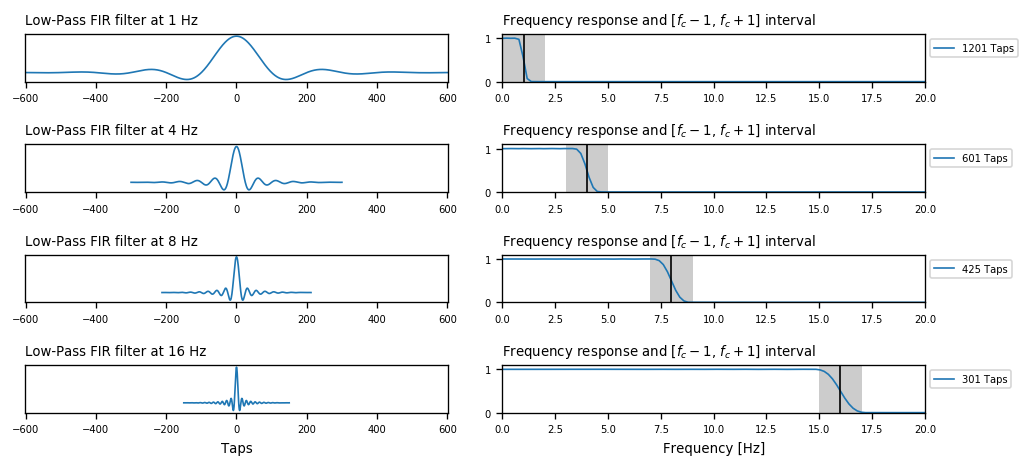

In [52]:
wave_expansion_factor = 0.5
numtaps_ref_list = [6 * fs]
cutoff_list = [1, 4, 8, 16]

n_rows = len(cutoff_list)
fig, ax = plt.subplots(n_rows, 2, figsize=(8, n_rows * 1), dpi=120)
max_taps = 0
for i, cutoff in enumerate(cutoff_list):
    for numtaps_ref in numtaps_ref_list:
        numtaps = numtaps_ref / (cutoff ** wave_expansion_factor)
        numtaps = 2 * int(numtaps // 2) + 1
        max_taps = max(numtaps // 2, max_taps)
        k_array = np.arange(numtaps) - numtaps // 2
        auto_filter = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs).astype(np.float32)
        auto_resp_freq, auto_resp_amp = utils.fir_freq_response(auto_filter, fs)
        ax[i, 0].plot(k_array, auto_filter, label="%d Taps" % numtaps, linewidth=general_lw)
        ax[i, 1].plot(auto_resp_freq, auto_resp_amp, label="%d Taps" % numtaps, linewidth=general_lw)
        ax[i, 1].set_xlim([0, 20])
        ax[i, 1].set_ylim([0, 1.1])
    ax[i, 1].axvline(cutoff, color="k", linewidth=general_lw)
    ax[i, 1].fill_between([cutoff-1, cutoff+1], 0, 1.1, facecolor="k", alpha=0.2)
    ax[i, 1].legend(fontsize=6, bbox_to_anchor=(1, 1), loc="upper left")
    ax[i, 0].set_title("Low-Pass FIR filter at %d Hz" % cutoff, loc="left",fontsize=viz.FONTSIZE_GENERAL)
    ax[i, 1].set_title(r"Frequency response and [$f_c-1$, $f_c+1$] interval", loc="left",fontsize=viz.FONTSIZE_GENERAL)
    ax[i, 0].set_yticks([])
ax[-1, 0].set_xlabel("Taps", fontsize=viz.FONTSIZE_GENERAL)
ax[-1, 1].set_xlabel("Frequency [Hz]", fontsize=viz.FONTSIZE_GENERAL)
for s_ax in ax:
    s_ax[0].set_xlim([-max_taps-1, max_taps+1])
for s_ax in ax.flatten():
    s_ax.tick_params(labelsize=6)
plt.tight_layout()
plt.show()

# Wave augmentation

### Check filters

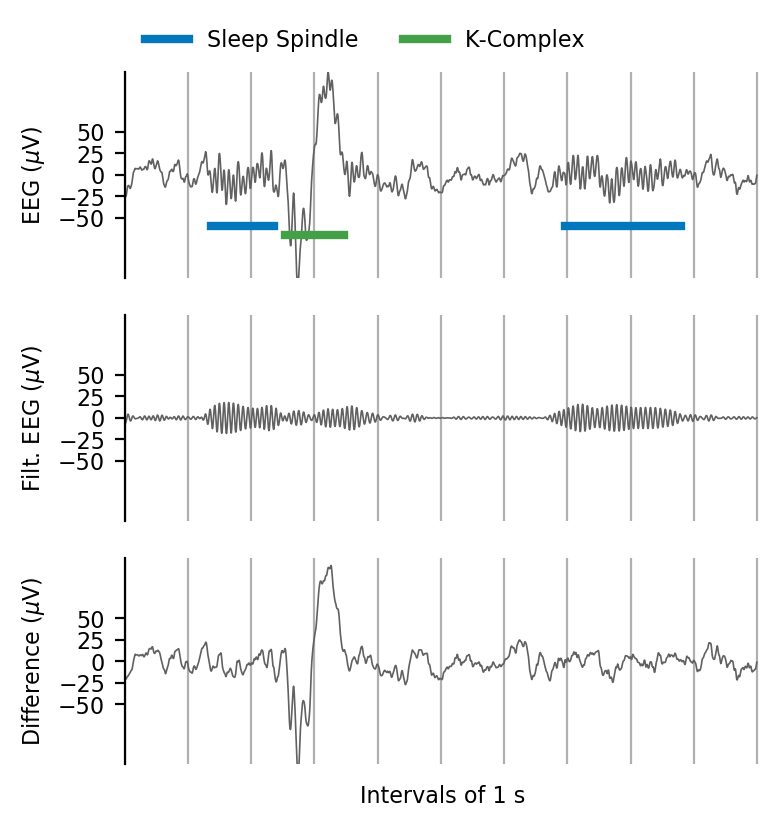

In [13]:
tf.reset_default_graph()
filt_signal_tf = wave_augment.bandpass_tf(segment_signal, fs, 11, 16)
with tf.Session() as sess:
    filt_signal = sess.run(filt_signal_tf)

fig, axes = plt.subplots(3, 1, dpi=200, figsize=(4, 4))
axes[0] = draw_signal(axes[0], segment_signal, xlabel="")
axes[0] = draw_stamps(axes[0], segment_stamps_ss, segment_stamps_kc)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axes[1] = draw_signal(axes[1], filt_signal, xlabel="", ylabel="Filt. EEG ($\mu$V)")
axes[2] = draw_signal(axes[2], segment_signal - filt_signal, ylabel="Difference ($\mu$V)")
plt.tight_layout()
plt.show()

### Check soft mask

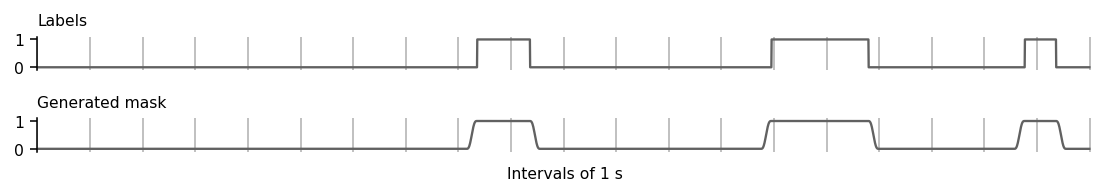

In [73]:
tf.reset_default_graph()
soft_mask_tf = wave_augment.generate_soft_mask_from_labels_tf(segment_label_ss, fs, use_background=False)
with tf.Session() as sess:
    soft_mask = sess.run(soft_mask_tf)

fig, axes = plt.subplots(2, 1, dpi=140, figsize=(8, 1.5))
axes[0].set_title("Labels", fontsize=viz.FONTSIZE_GENERAL, loc="left")
axes[0] = draw_signal(axes[0], segment_label_ss, xlabel="", ylabel="", yticks=[0, 1], y_min=-0.1, y_max=1.1, linewidth=1.2)
axes[1].set_title("Generated mask", fontsize=viz.FONTSIZE_GENERAL, loc="left")
axes[1] = draw_signal(axes[1], soft_mask, ylabel="", yticks=[0, 1], y_min=-0.1, y_max=1.1, linewidth=1.2)
plt.tight_layout()
plt.show()

### Random wave generation

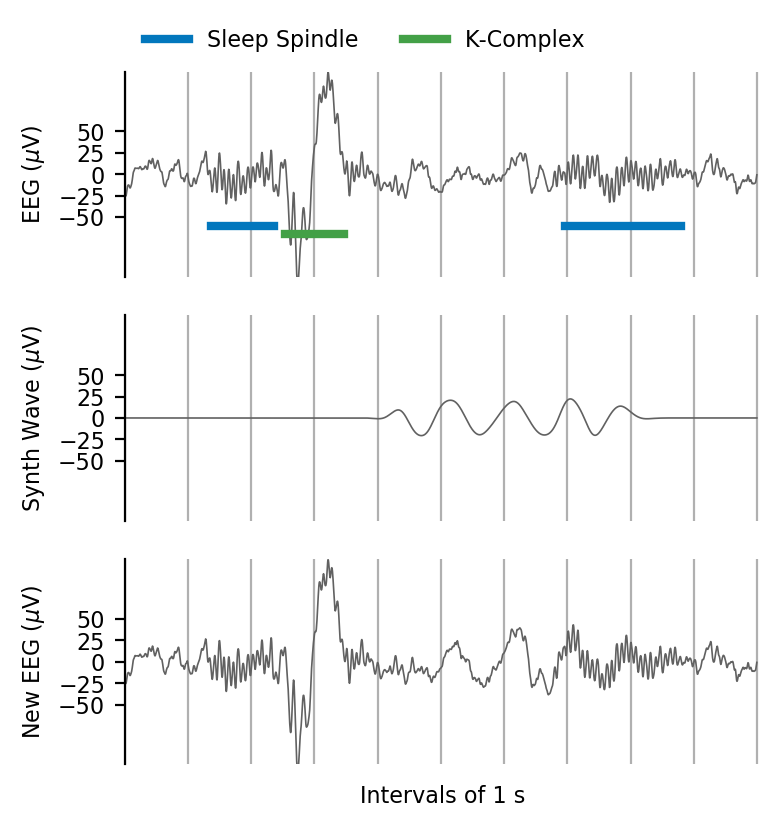

In [34]:
tf.reset_default_graph()
random_wave_tf = wave_augment.generate_wave_tf(
    segment_signal.size, fs,
    max_amplitude=30,  
    min_frequency=1,  #8
    max_frequency=2,  #10
    frequency_deviation=0.5,  #2  
    min_duration=3,  #1
    max_duration=5,  #5
    mask=None, #wave_augment.generate_soft_mask_from_labels_tf(segment_label_ss, fs, use_background=True)
)
new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])

fig, axes = plt.subplots(3, 1, figsize=(4, 4), dpi=200)
axes[0] = draw_signal(axes[0], segment_signal, xlabel="")
axes[0] = draw_stamps(axes[0], segment_stamps_ss, segment_stamps_kc)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axes[1] = draw_signal(axes[1], random_wave, xlabel="", ylabel="Synth Wave ($\mu$V)")
axes[2] = draw_signal(axes[2], new_signal, ylabel="New EEG ($\mu$V)")
plt.tight_layout()
plt.show()

### Many random waves generation

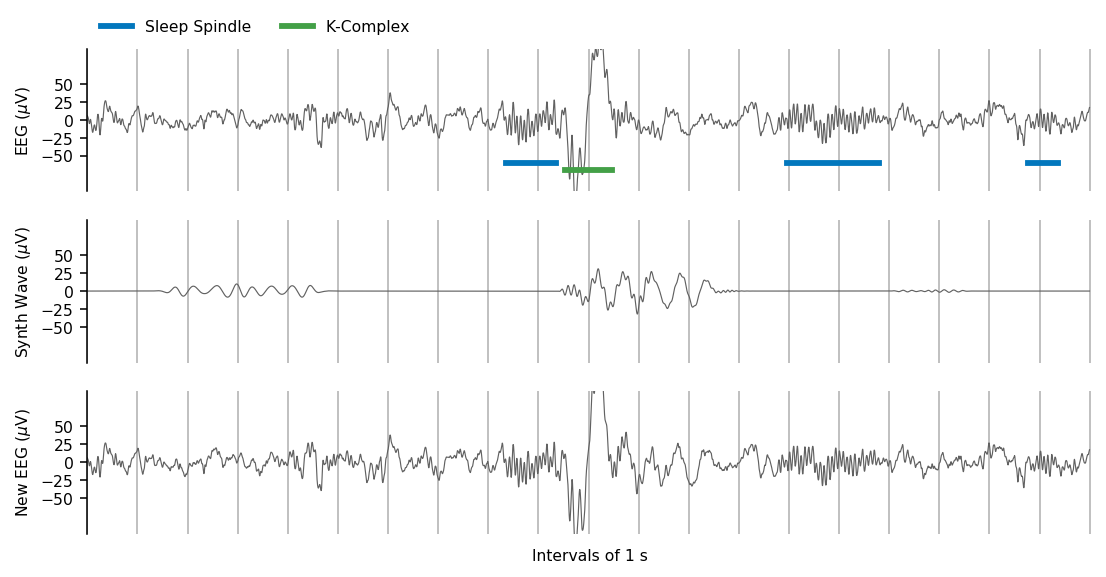

In [77]:
tf.reset_default_graph()

mask_keep_labels = wave_augment.generate_soft_mask_from_labels_tf(segment_label_ss, fs, use_background=False)
mask_keep_background = 1 - mask_keep_labels

max_amplitude_list = [30, 20, 15, 5, 15, 5]  # Signal units
min_frequency_list = [1, 2, 5, 5, 8, 8]  # Hz
max_frequency_list = [2, 3.5, 7, 7, 10, 10]  # Hz
frequency_deviation_list = [0.5, 1, 2, 2, 2, 2]  # Hz
min_duration_list = [3, 2, 1, 1, 1, 1]  # s
max_duration_list = [5, 5, 5, 5, 5, 5]  # s
mask_list = [None, None, mask_keep_background, None, mask_keep_background, None]

random_wave_tf = 0
for i in range(len(max_amplitude_list)):
    random_wave_tf += wave_augment.generate_wave_tf(
        segment_signal.size, fs,
        max_amplitude=max_amplitude_list[i],  
        min_frequency=min_frequency_list[i],
        max_frequency=max_frequency_list[i],
        frequency_deviation=frequency_deviation_list[i],  
        min_duration=min_duration_list[i],
        max_duration=max_duration_list[i],
        mask=mask_list[i])
new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])

fig, axes = plt.subplots(3, 1, figsize=(8, 4), dpi=140)
axes[0] = draw_signal(axes[0], segment_signal, xlabel="")
axes[0] = draw_stamps(axes[0], segment_stamps_ss, segment_stamps_kc)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axes[1] = draw_signal(axes[1], random_wave, xlabel="", ylabel="Synth Wave ($\mu$V)")
axes[2] = draw_signal(axes[2], new_signal, ylabel="New EEG ($\mu$V)")
plt.tight_layout()
plt.show()

### Random wave attenuation

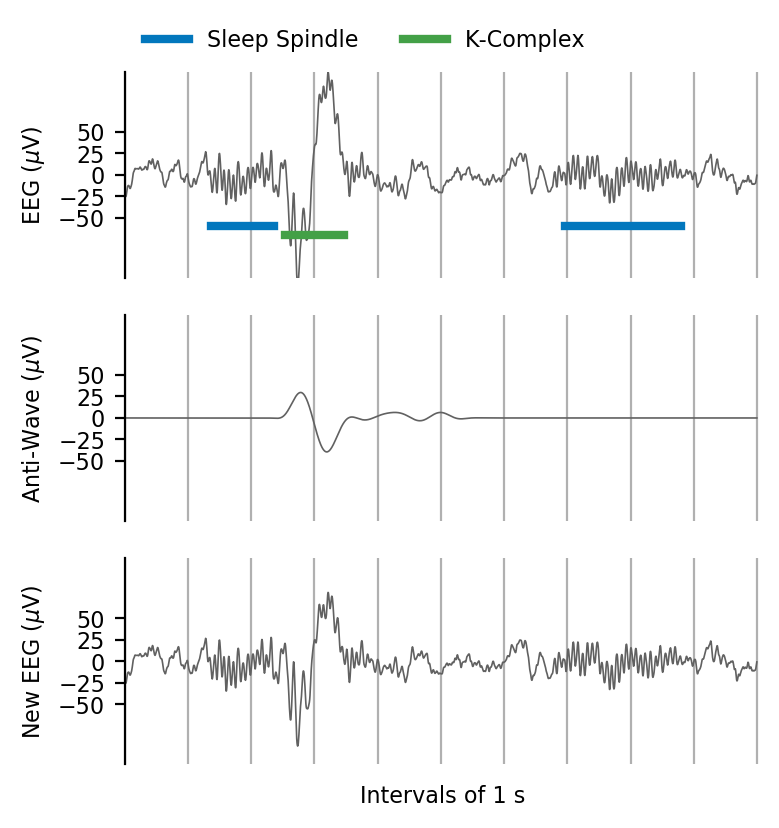

In [56]:
tf.reset_default_graph()
random_wave_tf = wave_augment.generate_anti_wave_tf(
    segment_signal,
    segment_signal.size, fs,
    max_attenuation=1,  
    lowcut=None,  #8
    highcut=2,  #10
    min_duration=3,  #1
    max_duration=5,  #5
    mask=None,
)
new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])

fig, axes = plt.subplots(3, 1, figsize=(4, 4), dpi=200)
axes[0] = draw_signal(axes[0], segment_signal, xlabel="")
axes[0] = draw_stamps(axes[0], segment_stamps_ss, segment_stamps_kc)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axes[1] = draw_signal(axes[1], random_wave, xlabel="", ylabel="Anti-Wave ($\mu$V)")
axes[2] = draw_signal(axes[2], new_signal, ylabel="New EEG ($\mu$V)")
plt.tight_layout()
plt.show()

### Many random waves attenuations

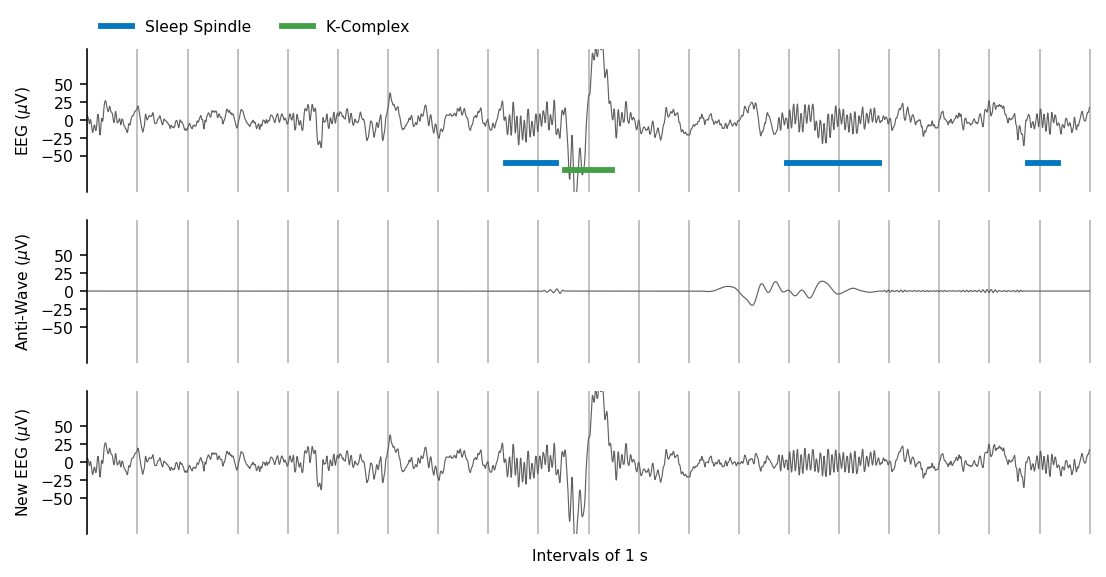

In [83]:
tf.reset_default_graph()

mask_keep_labels = wave_augment.generate_soft_mask_from_labels_tf(segment_label_ss, fs, use_background=False)
mask_keep_background = 1 - mask_keep_labels

max_attenuation_list = [1, 1, 1, 1, 1]  # [0, 1]
lowcut_list = [None, 2, 4, 7, 11]  # Hz
highcut_list = [2, 4, 7, 10, 16]  # Hz
min_duration_list = [3, 2, 1, 1, 1]  # s
max_duration_list = [5, 5, 5, 5, 5]  # s
mask_list = [None, None, mask_keep_labels, mask_keep_labels, mask_keep_background]

random_wave_tf = 0
for i in range(len(max_attenuation_list)):
    random_wave_tf += wave_augment.generate_anti_wave_tf(
        segment_signal + random_wave_tf,
        segment_signal.size, fs,
        max_attenuation=max_attenuation_list[i],  
        lowcut=lowcut_list[i],
        highcut=highcut_list[i],
        min_duration=min_duration_list[i],
        max_duration=max_duration_list[i],
        mask=mask_list[i])
new_signal_tf = random_wave_tf + segment_signal

with tf.Session() as sess:
    new_signal, random_wave = sess.run([new_signal_tf, random_wave_tf])
    
fig, axes = plt.subplots(3, 1, figsize=(8, 4), dpi=140)
axes[0] = draw_signal(axes[0], segment_signal, xlabel="")
axes[0] = draw_stamps(axes[0], segment_stamps_ss, segment_stamps_kc)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
axes[1] = draw_signal(axes[1], random_wave, xlabel="", ylabel="Anti-Wave ($\mu$V)")
axes[2] = draw_signal(axes[2], new_signal, ylabel="New EEG ($\mu$V)")
plt.tight_layout()
plt.show()

In [88]:
# Generate params_dict_list


max_amplitude_list = [30, 20, 15, 5, 15, 5]  # uV, needs normalization
min_frequency_list = [1, 2, 5, 5, 8, 8]  # Hz
max_frequency_list = [2, 3.5, 7, 7, 10, 10]  # Hz
frequency_deviation_list = [0.5, 1, 2, 2, 2, 2]  # Hz
min_duration_list = [3, 2, 1, 1, 1, 1]  # s
max_duration_list = [5, 5, 5, 5, 5, 5]  # s
mask_list = ["mask_none", "mask_none", "mask_keep_background", "mask_none", "mask_keep_background", "mask_none"]

random_waves_params = [
    dict(
        max_amplitude=max_amplitude_list[i],  
        min_frequency=min_frequency_list[i],
        max_frequency=max_frequency_list[i],
        frequency_deviation=frequency_deviation_list[i],  
        min_duration=min_duration_list[i],
        max_duration=max_duration_list[i],
        mask=mask_list[i])
    for i in range(len(max_amplitude_list))
]

pprint(params_dict_list)

[{'frequency_deviation': 0.5,
  'mask': 'mask_none',
  'max_amplitude': 30,
  'max_duration': 5,
  'max_frequency': 2,
  'min_duration': 3,
  'min_frequency': 1},
 {'frequency_deviation': 1,
  'mask': 'mask_none',
  'max_amplitude': 20,
  'max_duration': 5,
  'max_frequency': 3.5,
  'min_duration': 2,
  'min_frequency': 2},
 {'frequency_deviation': 2,
  'mask': 'mask_keep_background',
  'max_amplitude': 15,
  'max_duration': 5,
  'max_frequency': 7,
  'min_duration': 1,
  'min_frequency': 5},
 {'frequency_deviation': 2,
  'mask': 'mask_none',
  'max_amplitude': 5,
  'max_duration': 5,
  'max_frequency': 7,
  'min_duration': 1,
  'min_frequency': 5},
 {'frequency_deviation': 2,
  'mask': 'mask_keep_background',
  'max_amplitude': 15,
  'max_duration': 5,
  'max_frequency': 10,
  'min_duration': 1,
  'min_frequency': 8},
 {'frequency_deviation': 2,
  'mask': 'mask_none',
  'max_amplitude': 5,
  'max_duration': 5,
  'max_frequency': 10,
  'min_duration': 1,
  'min_frequency': 8}]
